#Lab 10

In this lab we will use transfer learning to perform classification of the Histopathology dataset "PathMNIST" from the [MedMNIST_v2 dataset](https://arxiv.org/pdf/2110.14795.pdf).

![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

The MedMNIST dataset is a MNIST like dataset with several classes of biomedical images, all fully labelled and converted to small 28 x 28 size. This dataset allows development & test of neural networks for biomedical applications.

This notebook is based on the [Tensorflow Transfer Learning tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning). The tutorial applied transfer learning on the "Cats and Dogs" dataset, which is a similar target domain to the ImageNet dataset that the available keras Image Classification models are trained on. Therefore even without fine tuning the MobileNet_v2 model in the tutorial achieved ~90% accuracy.

Applying Transfer Learning to biomedical data is more difficult as the target domain is very different to source ImageNet domain, and fine tuning of the features will be necessary to achieve good performance.

In this Etivity we will follow the same approach as the Tensorflow Tutorial. Initially we will just use the pre-trained network as a Feature Extractor. We will then apply Fine Tuning to improve the performance of the network.

The notebook Contains the Following Steps
*  1. Import Dataset
*  2. A) **Create base Model** (You can modify the base model to find a more suitable model for this application)
* 2. B) **New Classifier Model with Feature Extraction** (You will need to add an appropriate classifier (dense layer) to the output of the feature extractor.)
* 3. A) Compile the Model
* 3. B) Train the Classifier Part of the model.
* 4. Fine Tune the Model (you will need to **set which layers** of your model to fine tune)
* 5. Evaluation and Prediction
* 6. ROC (receiver operator Curves) and AUC (Area under the curve).
  

The Goal of the Etivity Assignment is to obtain the highest possible accuracy on the PathMNIST test dataset with transfer learning. You can experiment with:

*   Using different Base models
*   Using only some of feature layers (avoid class/object specific layers)
*   Fine tuning different numbers of layers.
*   Classifier with additional (dense) layers other than output layer.
*  Including Data Augmentation


Please leave any comments on your approach at the end of the notebook. It is again recommended to approach this assignment systematically. Record the results after each run, before making changes to improve performance.



## House Keeping

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm


## 1. Import Dataset
Download the [MedMNIST_v2 Dataset .npz files](https://zenodo.org/record/6496656#.Y-4IA3bP07M) from the repository.  Convert this information to a tensorflow dataset with `from_tensor_slices`

In [2]:
DATA_URL = 'https://zenodo.org/record/6496656/files/pathmnist.npz'

path = tf.keras.utils.get_file('pathmnist.npz', DATA_URL)
with np.load(path) as data:
  train_images = data['train_images']
  train_labels = data['train_labels']
  val_images = data['val_images']
  val_labels = data['val_labels']
  test_images = data['test_images']
  test_labels = data['test_labels']

205615438/205615438 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [4]:
print('number of train Images =', np.shape(train_images)[0])
print('number of test Images =', np.shape(test_images)[0])

number of train Images = 89996
number of test Images = 7180


Shuffle the dataset on each epoch and add batching. Add Resize to 32 x 32 for compatibility with pre-trained models minimum input size.

In [5]:
IMG_SIZE = (28, 28)
BATCH_SIZE = 12
SHUFFLE_BUFFER_SIZE = 100

#normalization_layer=tf.keras.layers.Rescaling(1./127.5, offset=-1)
#zero_pad = tf.keras.layers.ZeroPadding2D(padding=(2, 2))
resize= tf.keras.layers.Resizing(32,32,interpolation='bilinear')

def image_pipe(image,label):
  # Pad to 32 x 32 and normalise for input to network
  image = resize(image)
  #image = normalization_layer(image)
  return image,label

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).map(image_pipe)
val_dataset = val_dataset.batch(BATCH_SIZE).map(image_pipe)
test_dataset = test_dataset.batch(BATCH_SIZE).map(image_pipe)

Display the number of Training, validation and test batches

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 834
Number of test batches: 599


Plot Some examples from the dataset

tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([4], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)


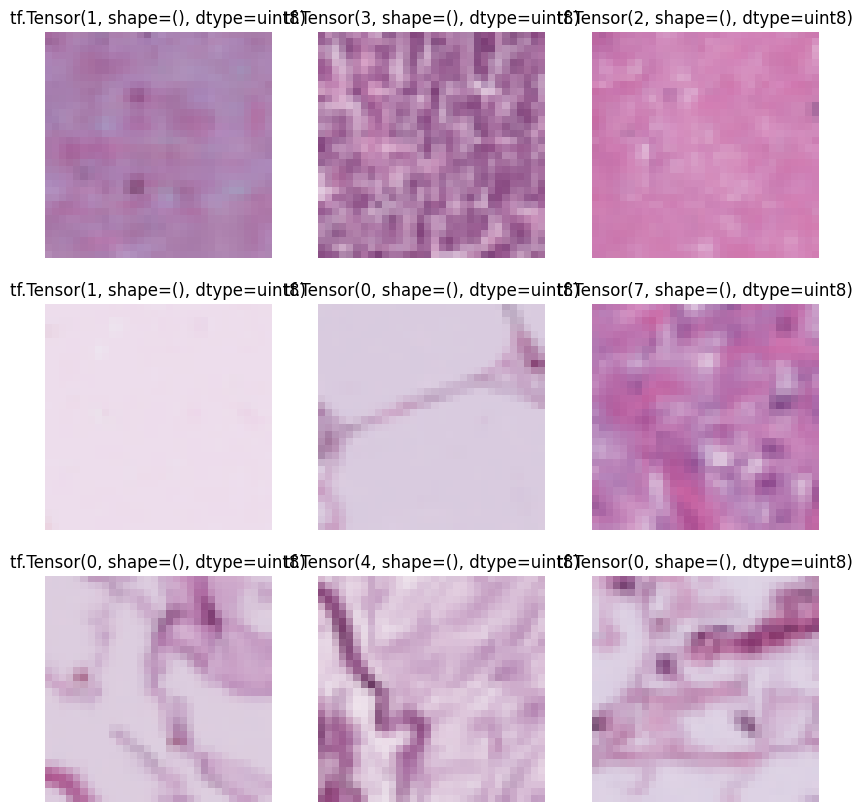

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    print(labels[i])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i][0]))
    plt.axis("off")

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

For Biomedical images we must be careful not to select transformations that distort the images in an unrealistic fashion. As the samples could appear in any orientation in the real world, a random flip is a reasonable transform and has been included as a default. You may experiment with more transforms. It is a good idea to run without data augmentation to begin. You can enable it when setting up your classifier model in section 2B

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])

Note: These augmentation layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

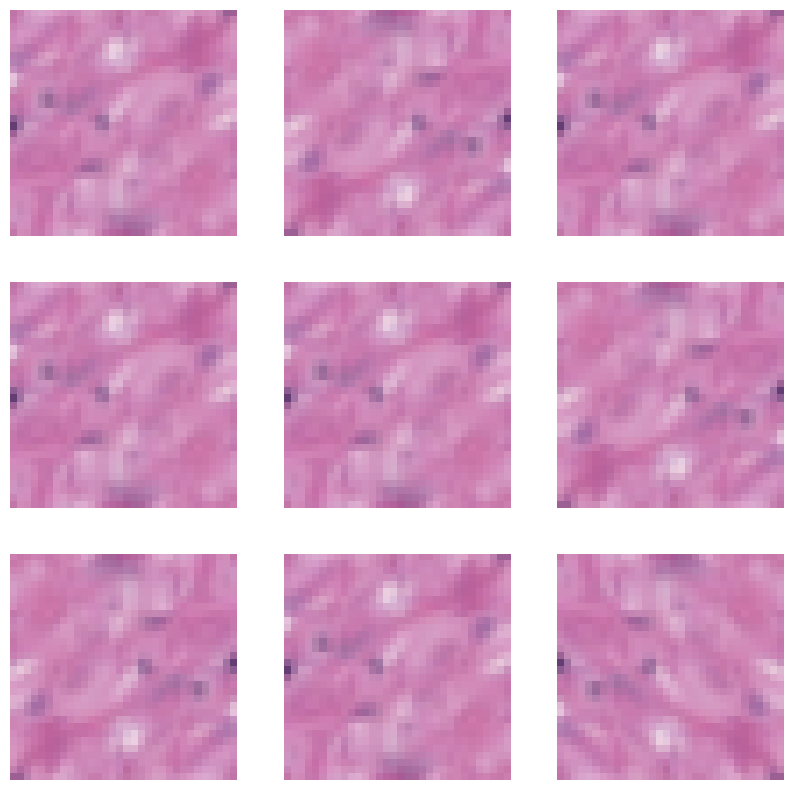

In [10]:
for images, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  #images = 127.5*(images)+128
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 2A. Create the base model from the pre-trained convnets
You will create the base model from one of the pretrained (ImageNet) models available in the [Keras Applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) API.


First, instantiate a model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

The mobileNet_v2 model from the oringinal Transfer learning tutorial included in the code cell below for reference. This may not be the most suitable model for the PathMNIST application.

In [11]:
## Change Base Model from Default MobileNetV2 ##
IMG_SHAPE = (32,32,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

<ipython-input-11-06d80f95f678>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


If you want to experiment with using only some of the layers of the Feature detector part of the base network, you can uncomment the code below. Note that a valid layer name must be inserted. You can see layer names by running base_model.summary(). You will need to replace the `base_model` with `base_model_x` in the later code so that this change is included.

In [ ]:
# Take only part of base model
#model_output = base_model.get_layer("conv3_block3_out").output
#base_model_x = tf.keras.Model(inputs=base_model.input, outputs=model_output)

In [12]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

## 2B. New Classifier Model with Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

* It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. All models have many layers, so setting the entire model's `trainable` flag to False will freeze all of them (This is done in the code cell below).
* The pixel values in the dataset images are in `[0, 255]`. Deep Neural networks must receive inputs with the same scale/offset as their original training data. To rescale the inputs, use the appropraite preprocessing method included with the model. (Case for mobileNet_2 shown in code cell)
* When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model (This is completed for the base_model in the code cell below). Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned. For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
* In the [Transfer Learning tutorial](https://www.tensorflow.org/guide/keras/transfer_learning) a global average pooling layer was used to average over the spatial 5x5 spatial locations layer of the output feature map, to convert the features to a single 1280-element vector per image. As the input image size is much smaller in this case the spatial size may be 1 x 1 in the deep layers (depending on the exact classifier model used). A flatten layer may be used to convert to a 1D vector for input to any dense layers in the classifier.
* The model in the tensorflow tutorial used a binary output. In this case there is a multi-class output. The [MedMNIST_v2 paper](https://arxiv.org/pdf/2110.14795.pdf) details the number of classes in the summary of the various datasets.  

Modify the feature extraction + classifier model (from Tensorflow Tutorial) for the PathMNIST case with 10 classes.  As shown you will chain together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as keras pre-trained models typically contain a `BatchNormalization` layer.


In [13]:
import tensorflow as tf

preprocess_input = tf.keras.applications.resnet50.preprocess_input

base_model = tf.keras.applications.ResNet50(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')

# Set trainable parameter to False
base_model.trainable = False

# Complete Classifier model with base_model Feature Extractor
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(9)(x)
outputs = tf.keras.layers.Activation('softmax')(outputs)
model = tf.keras.Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 3A. Compile the model

In the tensorflow transfer learning tutorial the model produced a binary output and the `tf.keras.losses.BinaryCrossentropy` loss was used. In this with multi-class outputs the `tf.keras.losses.SparseCategoricalCrossentropy` loss should be used. The sparse refers to the fact that the labels are given as integer values rather than as 1 hot values. The `from_logits=False` assuming class probabilities sum to 1.

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 32, 32)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 32, 32)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 32, 32)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 32, 32, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 3)      │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 1, 1, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 9)              │         18,441 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 9)              │              0 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 3B. Train the model

The model should initially be trained for a limited number of Epochs, as with the reasonably large size dataset (PathMNIST) the model will train well over just a single epoch.


In [17]:
initial_epochs = 4

loss0, accuracy0 = model.evaluate(val_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

834/834 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.0356 - loss: 8.3769
initial loss: 8.31
initial accuracy: 0.03


In [18]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.05, patience=3) # callbacks=[callback]
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - accuracy: 0.5559 - loss: 1.7056 - val_accuracy: 0.7926 - val_loss: 0.5795
Epoch 2/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - accuracy: 0.7674 - loss: 0.6546 - val_accuracy: 0.8118 - val_loss: 0.5266
Epoch 3/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.7924 - loss: 0.5794 - val_accuracy: 0.8169 - val_loss: 0.5089
Epoch 4/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.8008 - loss: 0.5550 - val_accuracy: 0.8150 - val_loss: 0.5091


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the base model as a fixed feature extractor.

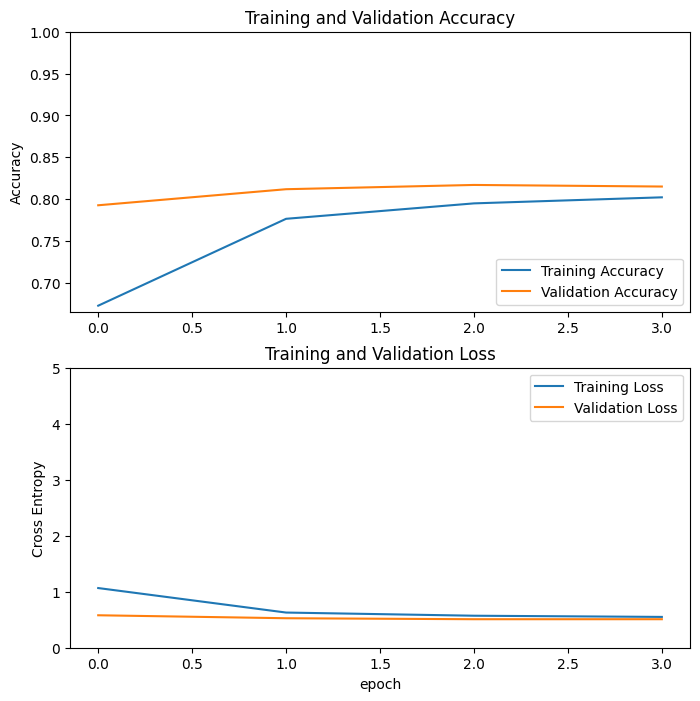

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer. In the code cell below we obtain the accuracy over the test set, which gives the best indication of the current performance of the model.

In [20]:
loss_, accuracy_ = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_)

599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7941 - loss: 0.5521
Test accuracy : 0.7937325835227966


## 4. Fine tuning
To further increase performance you can "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the classifier you added.

The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also as was done in the Tensorflow Transfer Learning tutorial, you should try to fine-tune a small number of top layers rather than the whole model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

Depending on the Model you are using you will have to determine which layers to Fine tune. The variable `fine_tune_at` in the code cell below allows you to set this.  You can use the function `print_layer_trainable` to list which layers will and will not be trained. You will need to understand the structure of the base model you are using to help decide which layers to fine tune. Many modern models have lots of layers when you include all the batch normalisation and activations as well as convolution and pooling. The [netscope viewer](https://dgschwend.github.io/netscope/quickstart.html) can be useful to understand the fine detail of networks.

In [21]:
# Intially set all model layers to be trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [22]:
short_model = tf.keras.Model(inputs,outputs)
def print_layer_trainable(conv_model):
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

print_layer_trainable(short_model)

True:	input_layer_3
True:	resnet50
True:	global_average_pooling2d
True:	dropout
True:	dense
True:	activation


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [23]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 32, 32)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 32, 32)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 32, 32)         │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 32, 32, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 3)      │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 1, 1, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 9)              │         18,441 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 9)              │              0 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 22,945,545 (87.53 MB)

 Non-trainable params: 660,608 (2.52 MB)

### Continue training the model

In [25]:
fine_tune_epochs = 6
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 219s 24ms/step - accuracy: 0.5659 - loss: 1.5163 - val_accuracy: 0.7529 - val_loss: 1.6243
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 170s 22ms/step - accuracy: 0.7338 - loss: 0.7778 - val_accuracy: 0.8068 - val_loss: 2.9051
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 204s 22ms/step - accuracy: 0.7862 - loss: 0.6084 - val_accuracy: 0.8430 - val_loss: 1.0322
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 165s 22ms/step - accuracy: 0.8211 - loss: 0.5113 - val_accuracy: 0.8535 - val_loss: 0.8362
Epoch 8/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 204s 22ms/step - accuracy: 0.8422 - loss: 0.4440 - val_accuracy: 0.8842 - val_loss: 0.3548
Epoch 9/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 201s 22ms/step - accuracy: 0.8657 - loss: 0.3846 - val_accuracy: 0.8691 - val_loss: 0.7464
Epoch 10/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 205s 23ms/step - accuracy: 0.8783 - loss: 0.3401 - val_accuracy: 0.8981 - val_loss: 0.3942


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the base model and training the classifier on top of it.


In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

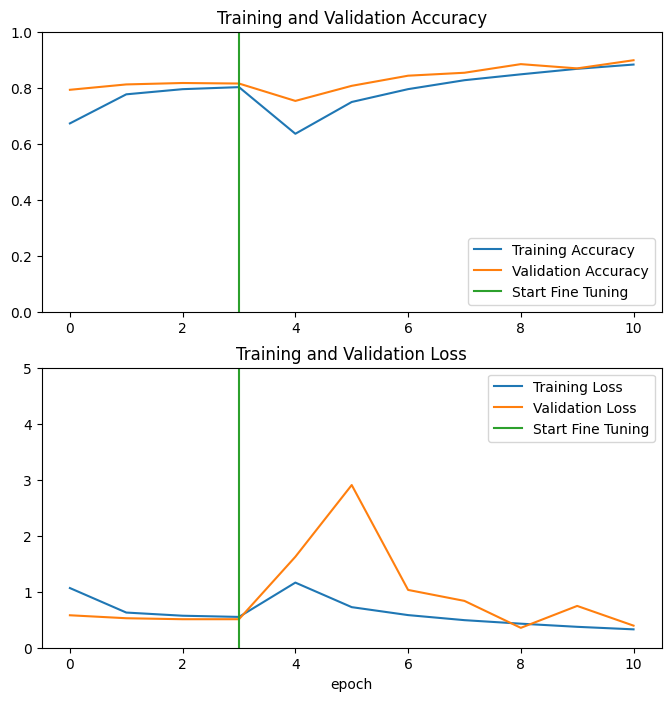

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 5. Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [28]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

599/599 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8386 - loss: 0.6700
Test accuracy : 0.8401114344596863


We can also obtain a confusion matrix by obtaining predictions from a number of batches.

In [29]:
n_test = 500 # number of batches to use
y_score = [] # Vector of raw probabilities produced by network
store_predictions = []
store_labels = []
cntr = 0
for image_batch,label_batch in test_dataset.take(n_test):
    probabilities = model.predict_on_batch(image_batch)
    y_score = np.concatenate((y_score,probabilities)) if (cntr >0) else probabilities
    predictions = tf.math.argmax(probabilities,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
    cntr +=1
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*BATCH_SIZE))) # Vector of predicted labels produced by network
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*BATCH_SIZE)))      # Vector of corresponding ground truth labels

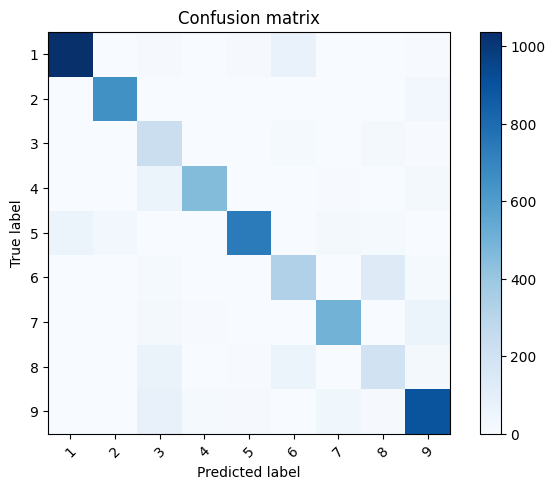

In [30]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
label_str=['1','2','3','4','5','6','7','8','9']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

           1       0.94      0.91      0.93      1138
           2       0.96      0.94      0.95       688
           3       0.48      0.84      0.61       277
           4       0.95      0.85      0.90       535
           5       0.96      0.85      0.90       859
           6       0.68      0.67      0.67       494
           7       0.88      0.82      0.85       600
           8       0.52      0.55      0.54       362
           9       0.84      0.85      0.85      1047

    accuracy                           0.84      6000
   macro avg       0.80      0.81      0.80      6000
weighted avg       0.86      0.84      0.84      6000



## 6. ROC Curves and AUC (Area under the curve) multi-class case

As detailed in the [MedMNIST_v2 paper](https://arxiv.org/pdf/2110.14795.pdf) Table 3->7 the AUC is used as a metric along with accuracy.
Multi-class receiver operator curves and the Macro-averaged AUC (Area under the curve) can be [obtained using sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) methods.

In [32]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_true)
label_binarizer.classes_
y_onehot_test = label_binarizer.transform(y_true)
y_onehot_test.shape  # (n_samples, n_classes)


(6000, 9)

In [33]:
from sklearn.metrics import roc_curve, auc,RocCurveDisplay


n_classes = 9
target_names = ['1','2','3','4','5','6','7','8','9']
fpr, tpr, roc_auc = dict(), dict(), dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.98


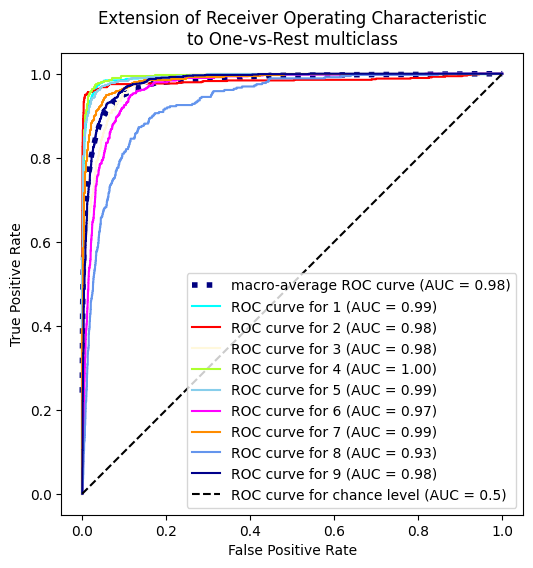

In [34]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua","red", "cornsilk","greenyellow","skyblue","fuchsia", "darkorange", "cornflowerblue","darkblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()